# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%bash
pip install .

Processing /Users/dwynne891/Documents/Options/optionlib
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for optionlib: filename=optionlib-0.1.0-py3-none-any.whl size=36260 sha256=1cbc91de502bfe3450910bfa0f6134abc49b77bc9c3c9259e09659a60009e58a
  Stored in directory: /private/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000gp/T/pip-ephem-wheel-cache-yrr7qljm/wheels/4d/62/1f/11cc5573a52206189c39d7fffa7bb24e2fafc7df16a30a71e1
Successfully built optionlib
  Attempting uninstall: optionlib
    Found existing installation: optionlib 0.1.0
    Uninstalling optionlib-0.1.0:
      Successfully uninstalled optionlib-0.1.0


In [141]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from joblib import Parallel, delayed
from plotly import express as px
import random

In [51]:
from scipy import stats

In [202]:
from optionlib import floating_quantile, menus, options
from optionlib.data import prices

In [267]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Load data

In [97]:
y = 2021

oc = pd.read_parquet(
    f'../historical_data/spx_option_chain_historical_{y}.parquet',
    filters=[('root','==','SPXW')]
)

iv_hist = pd.read_parquet('../historical_data/iv_timeseries_trading_days.parquet')

spx_prices = pd.read_parquet('../historical_data/spx_price_history.parquet').sort_index()

oc = oc.loc[lambda x: x.strike.between(x.underlying_ask*0.8,x.underlying_ask*1.2)]

oc = oc.assign(
    expiration = lambda x: pd.to_datetime(x.expiration),
    midpoint = lambda x: prices.rounded_midpoint(x.bid,x.ask,0.05)
).rename(
    columns = lambda x: x.capitalize()
).rename(
    columns = {'Option_type':'put_call'}
).set_index(['Quote_datetime','put_call','Strike'],drop = False)

trading_days = list(pd.concat([oc.Expiration,oc.Quote_datetime]).sort_values().dt.date.unique())

oc = oc.assign(
    dte = lambda x: x.Expiration.apply(lambda y: trading_days.index(y.date()))
        - x.Quote_datetime.apply(lambda y: trading_days.index(y.date()))
)

# Backtest

## Exhaustive search

In [ ]:
max_combos = 50_000
trades = dict()
trade_quantiles = dict()
bankroll = 6e4
date_range = oc.index.get_level_values(0).unique()[::dte+1]
bankroll_hist = pd.DataFrame(index = date_range,columns = ['bankroll','contracts'])
kelly_ratio = 0.5

for dt_raw in date_range:
    print(f'{dt_raw}, ${round(bankroll,2):,}')
    dt_str = str(dt_raw.date())
    data_trunc = data.loc[:dt_str]
    price = spx_prices.loc[dt_raw].open.values[0]
    
    model_obj = model.Model(
        data_trunc.ffill(),
        horizon = dte,
        eval_date = dt_str
    )
    
    floating_quintile = floating_quantile(
            iv = iv_hist.loc[dt_str].values[0],
            y = model_obj.y,
            iv_hist = iv_hist
        )

    oc_slice = oc.loc[dt_str,:].droplevel(0)
    strikes = oc_slice.index.get_level_values('Strike')
    bounds_raw = tuple(round(i) for i in floating_quintile.agg(['min','max']).add(1).multiply(price))
    bounds = tuple(
        strikes[abs(strikes - i).argmin()] for i in bounds_raw
    )

    menu = menus.TradeMenu(
        oc_slice,
        price,
        floating_quintile,
        bounds = bounds,
        midpoint_price = True
    )
    
    menu.iron_condors(
        downsample = max_combos,
        win_pct_bounds = (0.6,0.99)
    )

    if len(menu.menu)>0:
        max_EV_harmonic_idx = menu.menu.EV_harmonic.idxmax()
    else:
        max_EV_harmonic_idx = np.nan

    if max_EV_harmonic_idx is not np.nan:
        menu_slice = menu.menu.loc[max_EV_harmonic_idx]
        trades[dt_str] = menu_slice
        trade_quantiles[dt_str] = menu.quantiles.loc[max_EV_harmonic_idx]
        
        exp_str = spx_prices.sort_index().loc[str(oc_slice.Expiration.max().date())].quote_datetime.max()
        price_close = spx_prices.loc[exp_str,'close'].values[0]
        
        payoff = (
            np.max([max_EV_harmonic_idx[1]-price_close,0])
            + np.min([price_close - max_EV_harmonic_idx[2],0])
            + np.min([max_EV_harmonic_idx[3]- price_close,0])
            + np.max([price_close- max_EV_harmonic_idx[4],0])
            - menu.menu.loc[max_EV_harmonic_idx,'cost']
        )*100
    
        contracts = min(
            np.floor(bankroll*menu_slice.kelly*kelly_ratio/(-menu_slice.max_loss)),
            20
        )
    
        bankroll += contracts * payoff
        bankroll_hist.loc[exp_str.date(),'bankroll'] = bankroll
        bankroll_hist.loc[exp_str.date(),'contracts'] = contracts
    

outcome = pd.concat(trades,axis = 1).T.assign(
    bankroll = bankroll_hist.dropna().bankroll.values,
    bankroll_delta = lambda x: x.bankroll.diff(),
    contracts = bankroll_hist.dropna().contracts.values
)

In [256]:
pd.concat(trades,axis = 1).T.assign(
    bankroll = bankroll_hist.dropna().bankroll.values,
    bankroll_delta = lambda x: x.bankroll.diff(),
    contracts = bankroll_hist.dropna().contracts.values
).to_csv('../backtest_results/2D_2023.csv')

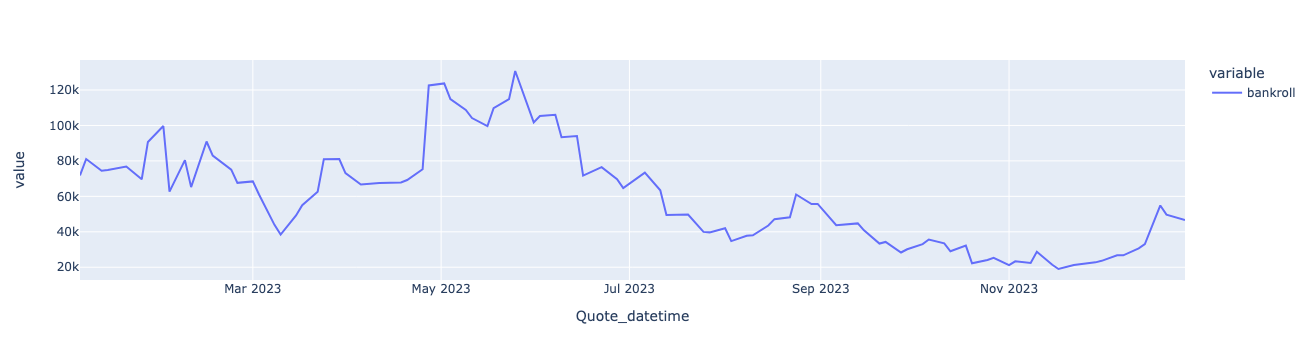

In [219]:
px.line(bankroll_hist.bankroll.dropna())

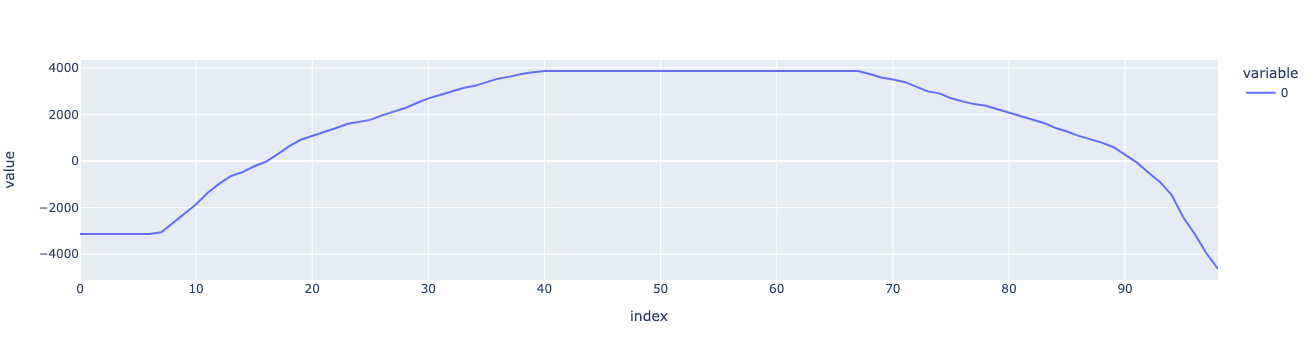

In [258]:
px.line(trade_quantiles['2023-02-01'].values)

In [ ]:
exp_str = spx_prices.sort_index().loc[str(oc_slice.Expiration.max().date())].quote_datetime.max()
        price_close = spx_prices.loc[exp_str,'close'].values[0]
        
        payoff = (
            np.max([max_EV_harmonic_idx[1]-price_close,0])
            + np.min([price_close - max_EV_harmonic_idx[2],0])
            + np.min([max_EV_harmonic_idx[3]- price_close,0])
            + np.max([price_close- max_EV_harmonic_idx[4],0])
            - menu.menu.loc[max_EV_harmonic_idx,'cost']
        )*100
    
        contracts = min(
            np.floor(bankroll*menu_slice.kelly*kelly_ratio/(-menu_slice.max_loss)),
            20
        )

## Tabu search

In [100]:
# Inputs
dte = 4
bankroll = 6e4
kelly_ratio = 0.5
win_pct_skew = 0.03
EV_floor = 1.003
win_pct_floor = .5

oc_dte = oc.loc[
    oc.dte.eq(dte) & oc.Quote_datetime.dt.time.eq(dt.time(hour = 10, minute = 30)),
    ['Bid','Ask','Midpoint','Expiration','Bid_size','Ask_size']
].sort_index()

trades = dict()
iv_ptile = dict()
date_range = oc_dte.index.get_level_values(0).unique()
exp_str = date_range[0] - np.timedelta64(1,'D')
bankroll_hist = pd.DataFrame(index = date_range,columns = ['bankroll','contracts'])

for dt_raw in date_range:

    if dt_raw <= exp_str:
        continue
    
    print(f'{dt_raw}, ${round(bankroll,2):,}')
    dt_str = str(dt_raw.date())
    data_trunc = spx_prices.loc[:dt_raw]
    price = spx_prices.loc[dt_raw].close.values[0]

    floating_quintile = floating_quantile.floating_quantile(
        dte=dte,
        iv = iv_hist.loc[dt_str,f'IV_{dte}'].values[0],
        y = spx_prices.loc[:dt_raw],
        iv_hist = iv_hist.loc[:dt_raw]
    )

    oc_slice = oc_dte.loc[dt_str,:].droplevel(0)
    strikes = oc_slice.index.get_level_values('Strike')
    bounds_raw = tuple(round(i) for i in floating_quintile.agg(['min','max']).add(1).multiply(price))
    bounds = tuple(
        strikes[abs(strikes - i).argmin()] for i in bounds_raw
    )

    menu = menus.TradeMenu(
        oc_slice,
        price,
        floating_quintile,
        bounds = bounds,
        midpoint_price = False
    )
    
    tabu_strikes, tabu_list = menu.iron_condors_search(
        max_iterations = 10,
        initial_sample = 1000,
        win_pct_skew = win_pct_skew
    )

    opt = options.OptionChain([
        menu.options['puts']['buy'][tabu_strikes[0]],
        menu.options['puts']['write'][tabu_strikes[1]],
        menu.options['calls']['write'][tabu_strikes[2]],
        menu.options['calls']['buy'][tabu_strikes[3]],
    ])
    contracts = min(
        np.floor(bankroll*opt.kelly*kelly_ratio/(-opt.max_loss)),
        20
    )
    IV_rank = stats.percentileofscore(
        iv_hist.loc[:dt_raw,f'IV_{dte}'].groupby('quote_datetime').mean().dropna(),
        iv_hist.loc[dt_str,f'IV_{dte}'].values[0],
        kind='rank'
    )
    print(
        'EV: ',round(opt.EV_harmonic*100,2),
        '\nWin %:',round(opt.win_pct*100,2),
        '\nContracts:', contracts,
        '\nIV ptile:', round(IV_rank,1)
    )
    
    
    if opt.EV_harmonic>EV_floor and opt.win_pct>win_pct_floor and contracts>0:
        trades[dt_str] = opt
        iv_ptile[dt_str] = IV_rank
        
        exp_str = spx_prices.loc[str(oc_slice.Expiration.max().date())].quote_datetime.max()
        price_close = spx_prices.loc[exp_str,'close'].values[0]
        
        payoff = (
            np.max([tabu_strikes[0]-price_close,0])
            + np.min([price_close - tabu_strikes[1],0])
            + np.min([tabu_strikes[2]- price_close,0])
            + np.max([price_close- tabu_strikes[3],0])
            - opt.price
        )*100
    
        contracts = min(
            np.floor(bankroll*opt.kelly*kelly_ratio/(-opt.max_loss)),
            20
        )
    
        bankroll += contracts * payoff
        bankroll_hist.loc[exp_str.date(),'bankroll'] = bankroll
        bankroll_hist.loc[exp_str.date(),'contracts'] = contracts

print(f'{exp_str}, ${round(bankroll,2):,}')
    
outcome = pd.DataFrame.from_dict(
    {i:[trades[i].EV_harmonic,trades[i].win_pct,trades[i].price] for i in trades},
    orient='index',
    columns = ['EV_harmonic','win_pct','price',]
).assign(
    bankroll = bankroll_hist.dropna().bankroll.values,
    bankroll_delta = lambda x: x.bankroll.diff(),
    contracts = bankroll_hist.dropna().contracts.values,
    EV_skewed = lambda x: x.EV_harmonic*(x.win_pct**win_pct_skew),
    iv_ptile = iv_ptile.values()
)

2021-01-04 10:30:00, $60,000.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.25 
Win %: 94.95 
Contracts: 1.0 
IV ptile: 85.0
2021-01-05 10:30:00, $60,000.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 1 iterations
EV:  102.37 
Win %: 90.91 
Contracts: 1.0 
IV ptile: 82.2
2021-01-12 10:30:00, $60,150.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.22 
Win %: 90.91 
Contracts: 0.0 
IV ptile: 70.4
2021-01-13 10:30:00, $60,150.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 1 iterations
EV:  100.4 
Win %: 90.91 
Contracts: 1.0 
IV ptile: 66.1
2021-01-21 10:30:00, $61,185.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.48 
Win %: 90.91 
Contracts: 1.0 
IV ptile: 52.5
2021-01-28 10:30:00, $58,082.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  104.26 
Win %: 70.71 
Contracts: 1.0 
IV ptile: 77.7
2021-02-04 10:30:00, $62,075.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  101.09 
Win %: 89.9 
Contracts: 1.0 
IV ptile: 46.8
2021-02-12 10:30:00, $63,135.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  101.23 
Win %: 85.86 
Contracts: 1.0 
IV ptile: 47.9
2021-02-22 10:30:00, $64,895.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 92.93 
Contracts: 0.0 
IV ptile: 72.7
2021-02-23 10:30:00, $64,895.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.55 
Win %: 89.9 
Contracts: 1.0 
IV ptile: 77.5
2021-03-02 10:30:00, $66,075.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.72 
Win %: 91.92 
Contracts: 1.0 
IV ptile: 87.5
2021-03-09 10:30:00, $67,115.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  103.57 
Win %: 69.7 
Contracts: 1.0 
IV ptile: 59.0
2021-03-16 10:30:00, $64,996.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.54 
Win %: 88.89 
Contracts: 1.0 
IV ptile: 51.6
2021-03-23 10:30:00, $65,696.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.06 
Win %: 93.94 
Contracts: 0.0 
IV ptile: 52.5
2021-03-25 10:30:00, $65,696.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.74 
Win %: 89.9 
Contracts: 1.0 
IV ptile: 61.4
2021-04-05 10:30:00, $66,966.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 1 iterations
EV:  102.44 
Win %: 67.68 
Contracts: 2.0 
IV ptile: 31.3
2021-04-12 10:30:00, $70,546.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 1 iterations
EV:  101.46 
Win %: 53.54 
Contracts: 2.0 
IV ptile: 51.6
2021-04-19 10:30:00, $80,016.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 87.88 
Contracts: 0.0 
IV ptile: 54.2
2021-04-20 10:30:00, $80,016.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.7min finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 86.87 
Contracts: 0.0 
IV ptile: 63.3
2021-04-22 10:30:00, $80,016.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.1min finished


Local maximum after 0 iterations
EV:  100.38 
Win %: 87.88 
Contracts: 2.0 
IV ptile: 47.9
2021-04-29 10:30:00, $81,536.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 90.91 
Contracts: 0.0 
IV ptile: 51.3
2021-05-03 10:30:00, $81,536.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.24 
Win %: 90.91 
Contracts: 1.0 
IV ptile: 39.1
2021-05-04 10:30:00, $81,536.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  101.82 
Win %: 44.44 
Contracts: 2.0 
IV ptile: 75.3
2021-05-06 10:30:00, $81,536.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 92.93 
Contracts: 0.0 
IV ptile: 71.8
2021-05-10 10:30:00, $81,536.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 3 iterations
EV:  100.0 
Win %: 95.96 
Contracts: 0.0 
IV ptile: 44.8
2021-05-11 10:30:00, $81,536.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 1 iterations
EV:  101.22 
Win %: 86.87 
Contracts: 1.0 
IV ptile: 81.3
2021-05-18 10:30:00, $83,477.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.5min finished


Local maximum after 0 iterations
EV:  100.82 
Win %: 86.87 
Contracts: 1.0 
IV ptile: 55.9
2021-05-25 10:30:00, $83,917.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.1min finished


Local maximum after 2 iterations
EV:  100.01 
Win %: 94.95 
Contracts: 0.0 
IV ptile: 51.7
2021-05-26 10:30:00, $83,917.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


Local maximum after 0 iterations
EV:  102.07 
Win %: 88.89 
Contracts: 3.0 
IV ptile: 29.3
2021-06-03 10:30:00, $87,667.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.89 
Win %: 90.91 
Contracts: 2.0 
IV ptile: 41.8
2021-06-10 10:30:00, $89,107.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  101.18 
Win %: 90.91 
Contracts: 2.0 
IV ptile: 18.8
2021-06-17 10:30:00, $90,267.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 17.9min finished


Local maximum after 0 iterations
EV:  100.24 
Win %: 93.94 
Contracts: 1.0 
IV ptile: 48.6
2021-06-21 10:30:00, $90,267.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 17.7min finished


Local maximum after 0 iterations
EV:  102.73 
Win %: 89.9 
Contracts: 3.0 
IV ptile: 30.9
2021-06-28 10:30:00, $90,717.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.4min finished


Local maximum after 0 iterations
EV:  100.32 
Win %: 95.96 
Contracts: 3.0 
IV ptile: 6.1
2021-07-06 10:30:00, $91,332.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 96.97 
Contracts: 0.0 
IV ptile: 34.4
2021-07-08 10:30:00, $91,332.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  101.14 
Win %: 88.89 
Contracts: 1.0 
IV ptile: 51.7
2021-07-15 10:30:00, $91,557.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.1min finished


Local maximum after 0 iterations
EV:  100.48 
Win %: 89.9 
Contracts: 1.0 
IV ptile: 41.7
2021-07-22 10:30:00, $92,377.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


Local maximum after 0 iterations
EV:  101.45 
Win %: 92.93 
Contracts: 3.0 
IV ptile: 29.2
2021-07-29 10:30:00, $94,357.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 1 iterations
EV:  101.84 
Win %: 94.95 
Contracts: 4.0 
IV ptile: 14.3
2021-08-05 10:30:00, $96,417.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.75 
Win %: 92.93 
Contracts: 2.0 
IV ptile: 25.8
2021-08-12 10:30:00, $97,657.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  100.77 
Win %: 93.94 
Contracts: 3.0 
IV ptile: 8.7
2021-08-19 10:30:00, $98,767.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


Local maximum after 0 iterations
EV:  109.47 
Win %: 71.72 
Contracts: 5.0 
IV ptile: 39.7
2021-08-26 10:30:00, $77,817.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.2min finished


Local maximum after 1 iterations
EV:  100.01 
Win %: 95.96 
Contracts: 0.0 
IV ptile: 45.8
2021-08-30 10:30:00, $77,817.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.3min finished


Local maximum after 0 iterations
EV:  100.69 
Win %: 93.94 
Contracts: 4.0 
IV ptile: 0.0
2021-09-07 10:30:00, $78,757.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 17.1min finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 96.97 
Contracts: 0.0 
IV ptile: 34.9
2021-09-09 10:30:00, $78,757.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


Local maximum after 0 iterations
EV:  101.08 
Win %: 92.93 
Contracts: 2.0 
IV ptile: 12.7
2021-09-16 10:30:00, $79,917.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.3min finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 96.97 
Contracts: 0.0 
IV ptile: 62.3
2021-09-20 10:30:00, $79,917.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.7min finished


Local maximum after 0 iterations
EV:  101.79 
Win %: 84.85 
Contracts: 1.0 
IV ptile: 88.3
2021-09-27 10:30:00, $80,827.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  102.56 
Win %: 87.88 
Contracts: 3.0 
IV ptile: 20.6
2021-10-04 10:30:00, $73,609.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  101.49 
Win %: 81.82 
Contracts: 2.0 
IV ptile: 92.2
2021-10-11 10:30:00, $77,399.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


Local maximum after 0 iterations
EV:  101.33 
Win %: 87.88 
Contracts: 2.0 
IV ptile: 49.9
2021-10-18 10:30:00, $77,429.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 1 iterations
EV:  104.51 
Win %: 85.86 
Contracts: 6.0 
IV ptile: 8.8
2021-10-25 10:30:00, $70,559.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.5min finished


Local maximum after 0 iterations
EV:  100.21 
Win %: 94.95 
Contracts: 1.0 
IV ptile: 20.5
2021-10-26 10:30:00, $70,559.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  102.34 
Win %: 74.75 
Contracts: 1.0 
IV ptile: 9.6
2021-11-02 10:30:00, $73,234.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 1 iterations
EV:  101.44 
Win %: 84.85 
Contracts: 1.0 
IV ptile: 32.7
2021-11-09 10:30:00, $73,284.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.5min finished


Local maximum after 0 iterations
EV:  104.43 
Win %: 47.47 
Contracts: 2.0 
IV ptile: 66.0
2021-11-11 10:30:00, $73,284.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.83 
Win %: 83.84 
Contracts: 1.0 
IV ptile: 50.6
2021-11-18 10:30:00, $74,434.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 84.85 
Contracts: 0.0 
IV ptile: 50.9
2021-11-19 10:30:00, $74,434.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  101.15 
Win %: 93.94 
Contracts: 2.0 
IV ptile: 30.5
2021-11-29 10:30:00, $70,648.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished


Local maximum after 0 iterations
EV:  100.8 
Win %: 91.92 
Contracts: 1.0 
IV ptile: 81.1
2021-12-06 10:30:00, $73,101.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  104.37 
Win %: 67.68 
Contracts: 1.0 
IV ptile: 81.0
2021-12-13 10:30:00, $69,489.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


Local maximum after 0 iterations
EV:  100.31 
Win %: 84.85 
Contracts: 1.0 
IV ptile: 72.6
2021-12-20 10:30:00, $70,493.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  103.19 
Win %: 81.82 
Contracts: 1.0 
IV ptile: 92.8
2021-12-28 10:30:00, $71,093.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.29 
Win %: 93.94 
Contracts: 1.0 
IV ptile: 37.4
2021-12-29 10:30:00, $71,093.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Local maximum after 0 iterations
EV:  100.0 
Win %: 90.91 
Contracts: 0.0 
IV ptile: 52.3
2021-12-30 10:30:00, $71,093.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


Local maximum after 0 iterations
EV:  105.8 
Win %: 80.81 
Contracts: 4.0 
IV ptile: 19.0
2022-01-07 16:15:00, $48,353.0


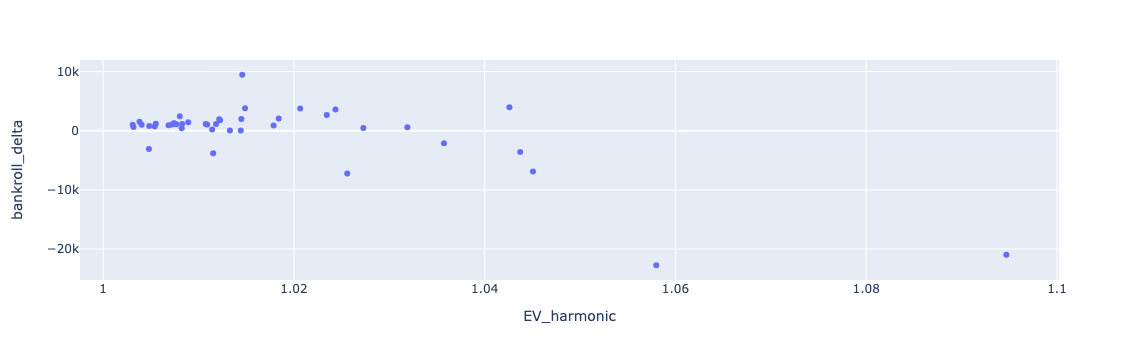

In [102]:
px.scatter(
    outcome,
    x = 'EV_harmonic',
    y = 'bankroll_delta'
)

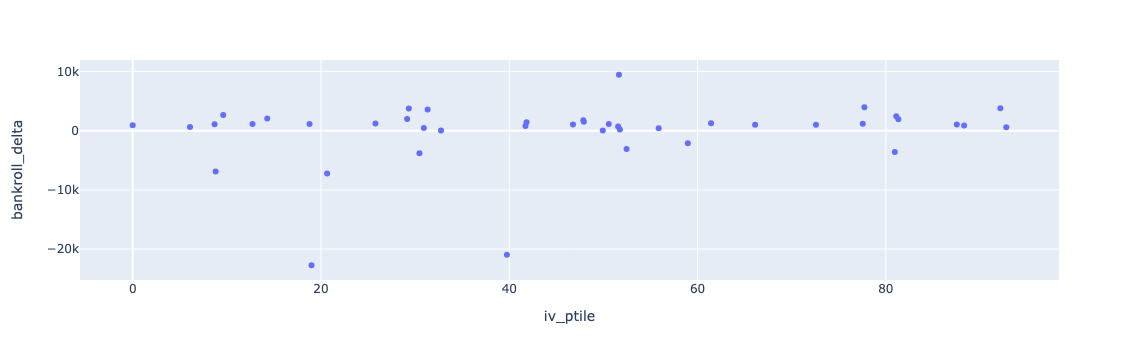

In [103]:
px.scatter(
    outcome,
    x = 'iv_ptile',
    y = 'bankroll_delta'
)

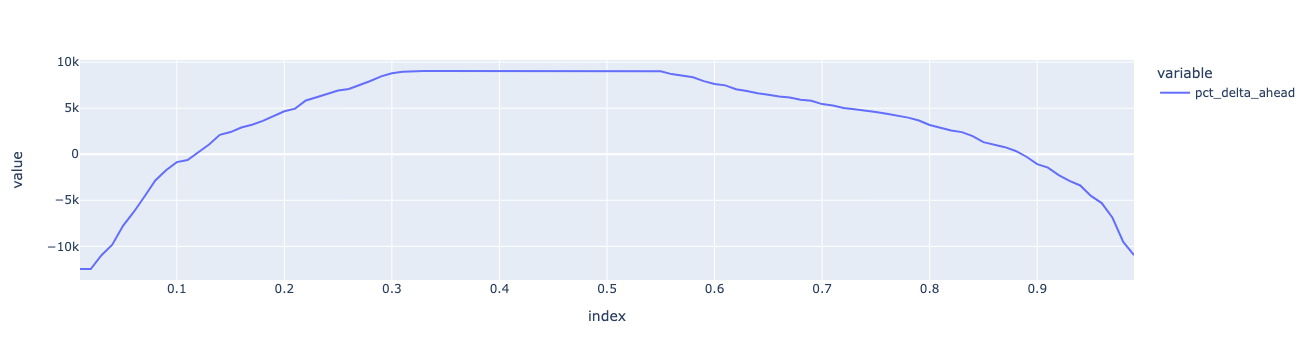

In [69]:
px.line(trades['2022-03-15'].payout)

In [76]:
outcome.bankroll_delta.gt(0).mean()

0.725

In [78]:
outcome.win_pct.mean()

0.7909090909090909

In [90]:
theoretical_EV = outcome.EV_harmonic.cumprod().iloc[-1]

In [91]:
theoretical_EV

2.7634167646837313

In [96]:
bankroll_hist.dropna().bankroll.iloc[-1]/6e4

1.2917666666666578

In [85]:
outcome

EV_harmonic   win_pct  price  bankroll bankroll_delta contracts  \
2023-01-05     1.032933  0.727273 -46.60   60320.0            NaN       2.0   
2023-01-13     1.115545  0.737374 -50.75   75545.0        15225.0       3.0   
2023-01-23     1.063045  0.696970 -55.35   78482.0         2937.0       3.0   
2023-01-30     1.017576  0.828283 -23.80   79946.0         1464.0       2.0   
2023-02-07     1.000370  0.858586  -5.35   80481.0          535.0       1.0   
2023-02-14     1.011408  0.787879 -35.70   71051.0        -9430.0       1.0   
2023-03-02     1.013715  0.767677 -36.20   73470.0         2419.0       1.0   
2023-03-09     1.012129  0.787879 -57.10   68373.0        -5097.0       1.0   
2023-03-16     1.076635  0.737374 -82.70   73446.0         5073.0       1.0   
2023-03-23     1.019279  0.838384 -40.20   75185.0         1739.0       1.0   
2023-03-31     1.025047  0.666667 -50.55   81291.0         6106.0       2.0   
2023-04-13     1.059485  0.717172 -27.95   93006.0        11715.0       5.0   
2023-04-20     1.011764  0.858586 -13.10   85233.0        -7773.0       3.0   
2023-04-27     1.022055  0.808081 -50.10   98988.0        13755.0       3.0   
2023-05-05     1.068750  0.717172 -44.05  116608.0        17620.0       4.0   
2023-05-18     1.061274  0.696970 -32.50  109252.0        -7356.0       6.0   
2023-05-25     1.000167  0.939394  -2.30  109482.0          230.0       1.0   
2023-06-02     1.006856  0.949495  -1.00  110982.0         1500.0      15.0   
2023-06-09     1.080934  0.707071 -24.45   75432.0       -35550.0      10.0   
2023-06-21     1.004532  0.757576  -9.55   77342.0         1910.0       2.0   
2023-06-28     1.020861  0.666667 -21.20   80156.0         2814.0       3.0   
2023-07-12     1.001956  0.919192  -1.90   80726.0          570.0       3.0   
2023-07-19     1.019427  0.737374 -19.00   84164.0         3438.0       3.0   
2023-07-27     1.000179  0.717172 -14.60   81124.0        -3040.0       1.0   
2023-08-10     1.000663  0.949495  -1.70   81464.0          340.0       2.0   
2023-08-23     1.008830  0.808081 -25.80   81544.0           80.0       1.0   
2023-08-31     1.008273  0.898990  -2.70   83434.0         1890.0       7.0   
2023-09-08     1.012666  0.848485  -5.95   86409.0         2975.0       5.0   
2023-09-28     1.002509  0.888889 -10.70   87479.0         1070.0       1.0   
2023-10-10     1.068221  0.747475 -30.60   99719.0        12240.0       4.0   
2023-10-17     1.039628  0.676768 -44.85   78674.0       -21045.0       3.0   
2023-10-24     1.036584  0.666667 -49.50   72938.0        -5736.0       2.0   
2023-10-31     1.003262  0.868687 -11.80   73118.0          180.0       1.0   
2023-11-07     1.003688  0.909091  -5.40   73658.0          540.0       1.0   
2023-11-14     1.079279  0.727273 -34.45   78486.0         4828.0       4.0   
2023-11-22     1.010303  0.696970 -10.60   80958.0         2472.0       4.0   
2023-12-05     1.024506  0.686869 -15.25   87058.0         6100.0       4.0   
2023-12-12     1.000651  0.919192  -1.90   81326.0        -5732.0       2.0   
2023-12-19     1.000212  0.929293  -1.65   81491.0          165.0       1.0   
2023-12-28     1.000349  0.787879 -10.15   77506.0        -3985.0       1.0   

            EV_skewed   iv_ptile  
2023-01-05   1.016616  72.612613  
2023-01-13   1.098681  31.488737  
2023-01-23   1.044028  40.286482  
2023-01-30   1.008035  88.995293  
2023-02-07   0.992773  70.438369  
2023-02-14   0.999423  56.448101  
2023-03-02   1.000403  63.505931  
2023-03-09   1.000136  79.569978  
2023-03-16   1.060359  93.790850  
2023-03-23   1.010334  58.055798  
2023-03-31   1.004475  41.844253  
2023-04-13   1.042020  20.979573  
2023-04-20   1.004080  31.146767  
2023-04-27   1.011223  50.427485  
2023-05-05   1.051132  33.539207  
2023-05-18   1.042289   9.514548  
2023-05-25   0.997045  60.974474  
2023-06-02   1.004250  17.386258  
2023-06-09   1.062361  11.266301  
2023-06-21   0.990684  39.360394  
2023-06-28   1.000373  12.872805  
20

# VIX and outcome %tile research

In [283]:
dte = 4

price_slice_open = spx_prices.loc[
    lambda x: (x.index.get_level_values('quote_datetime').time == (dt.time(hour = 10, minute = 30))),
    ['open']
].droplevel('Date').reset_index().assign(
    expiration_quote_datetime = lambda x: pd.to_datetime(x.quote_datetime.shift(-dte).dt.date) + pd.to_timedelta(16.25,unit = 'h')
).set_index(['quote_datetime','expiration_quote_datetime'])

price_slice_close = spx_prices.loc[
    lambda x: (x.index.get_level_values('quote_datetime').time == (dt.time(hour = 16, minute = 15))),
    ['close']
].droplevel('Date').reset_index().rename(
    columns = lambda x: 'expiration_'+x
).set_index(['expiration_quote_datetime'])

price_slice = price_slice_open.join(price_slice_close).iloc[:-dte].assign(
    pct_return = lambda x: x.expiration_close/x.open-1
)

del(price_slice_open,price_slice_close)

iv_slice = iv_hist.loc[
    lambda x: x.index.get_level_values('quote_datetime').time == (dt.time(hour = 10, minute = 30)),
    [f'IV_{dte}']
].groupby('quote_datetime').mean().dropna().assign(
    iv_ptile = np.nan,
    pct_return_ptile = np.nan
).join(price_slice)

In [284]:
dt_range = iv_slice.index.get_level_values('quote_datetime')[-252*8:]
quintile_dict = dict()

for d in dt_range:
    
    iv_slice.loc[d,'iv_ptile'] = stats.percentileofscore(
        iv_slice.loc[:d,f'IV_{dte}'],
        iv_slice.loc[d,f'IV_{dte}'],
        kind='rank'
    )
    
    floating_quintile = floating_quantile.floating_quantile(
        dte=dte,
        iv = iv_slice.loc[d,f'IV_{dte}'].values[0],
        y = spx_prices.loc[:d],
        iv_hist = iv_hist.loc[:d]
    )

    iv_slice.loc[d,'pct_return_ptile'] = abs(
        floating_quintile - iv_slice.loc[d,'pct_return'].values[0]
    ).idxmin()

iv_slice = iv_slice.dropna().assign(
    pct_return_median_distance = lambda x: abs(x.pct_return_ptile - 0.5)
)

/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000gp/T/ipykernel_23953/711064231.py:19: FutureWarning:

The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000gp/T/ipykernel_23953/711064231.py:19: FutureWarning:

The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000gp/T/ipykernel_23953/711064231.py:19: FutureWarning:

The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000gp/T/ipykernel_23953/711064231.py:19: FutureWarning:

The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000

In [ ]:
df.groupby(pd.qcut(df.A, 10))['A'].sum()

In [352]:
decile_share = iv_slice.loc['2018-01-01':].groupby([
    iv_slice.loc['2018-01-01':].iv_ptile.div(10).apply(np.floor).replace({10:9}),
    iv_slice.loc['2018-01-01':].pct_return_ptile.multiply(10).apply(np.floor),
]).size().unstack(0).apply(lambda x: x/x.sum(),axis = 0)

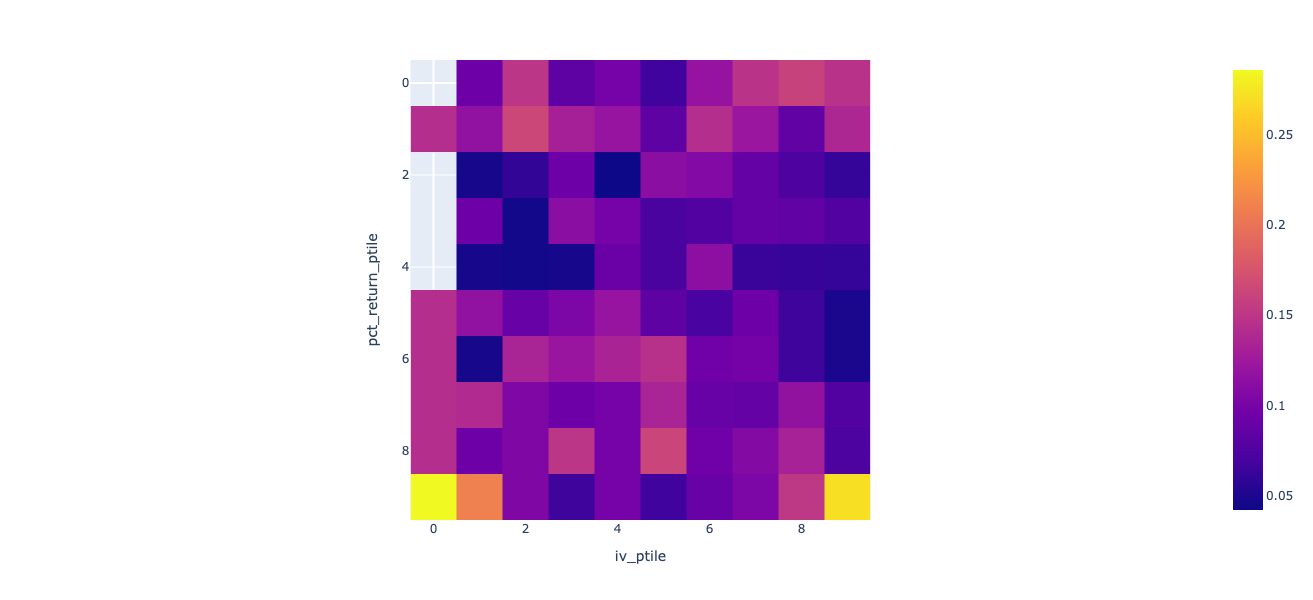

In [354]:
px.imshow(decile_share,height = 600)

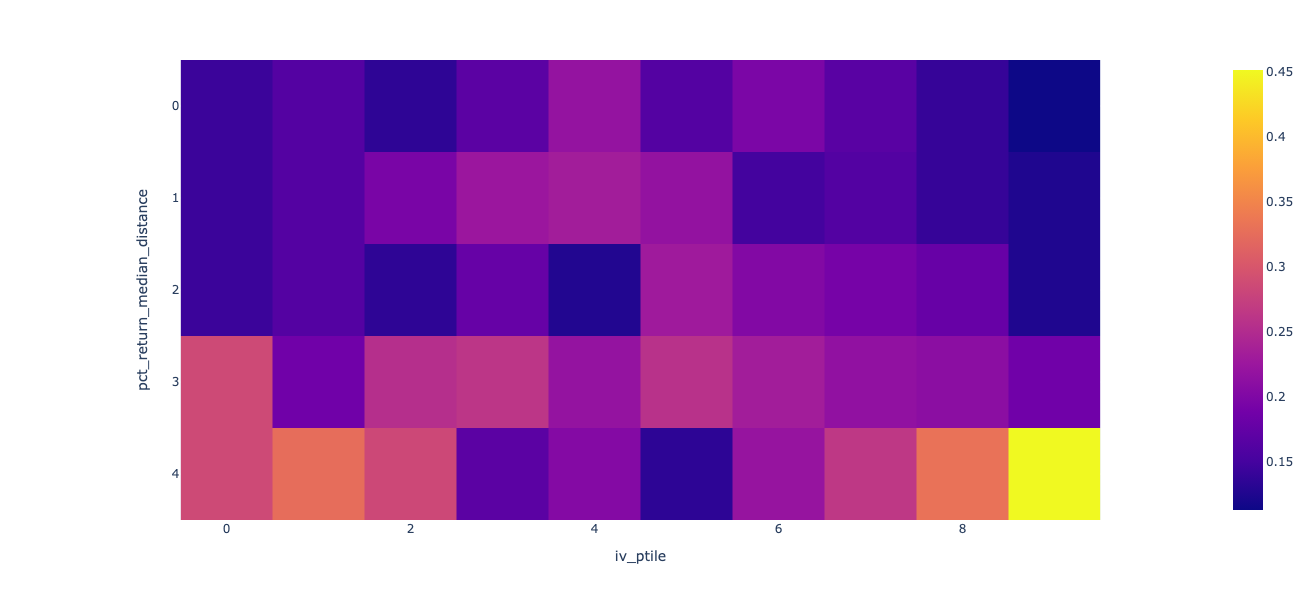

In [383]:
decile_share = iv_slice.loc['2018-01-01':].groupby([
    iv_slice.loc['2018-01-01':].iv_ptile.div(10).apply(np.floor).replace({10:9}),
    iv_slice.loc['2018-01-01':].pct_return_median_distance.multiply(10).apply(np.floor),
]).size().unstack(0).apply(lambda x: x/x.sum(),axis = 0)

px.imshow(decile_share,height = 600)

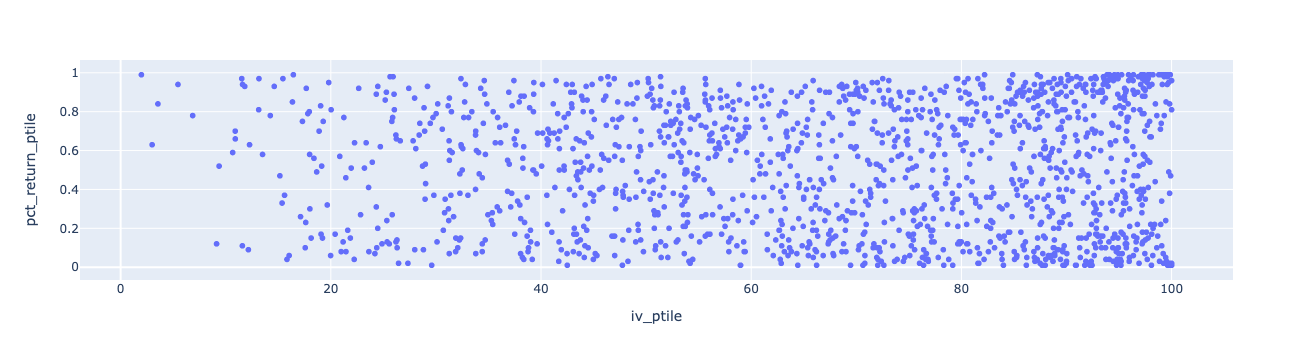

In [331]:
px.scatter(
    iv_slice.loc['2018-01-01':],
    x = 'iv_ptile',
    y = 'pct_return_ptile'
)

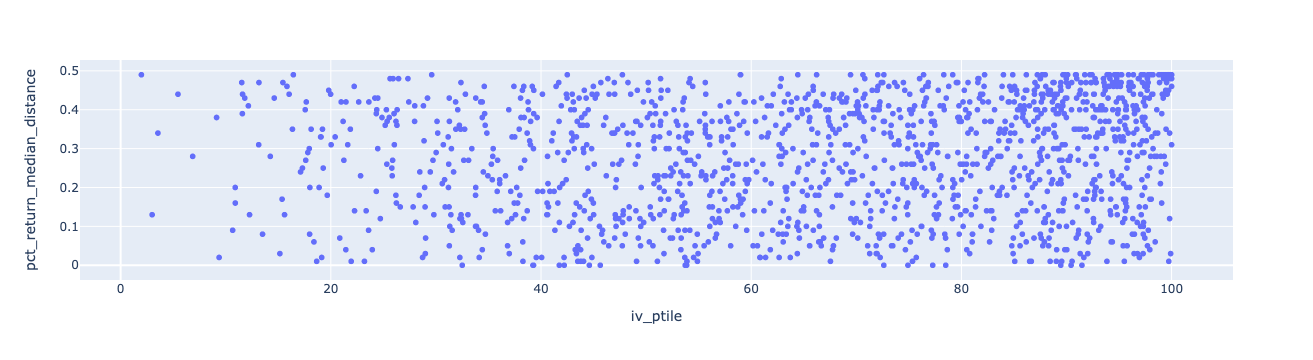

In [357]:
px.scatter(
    iv_slice.loc['2018-01-01':],
    x = 'iv_ptile',
    y = 'pct_return_median_distance'
)

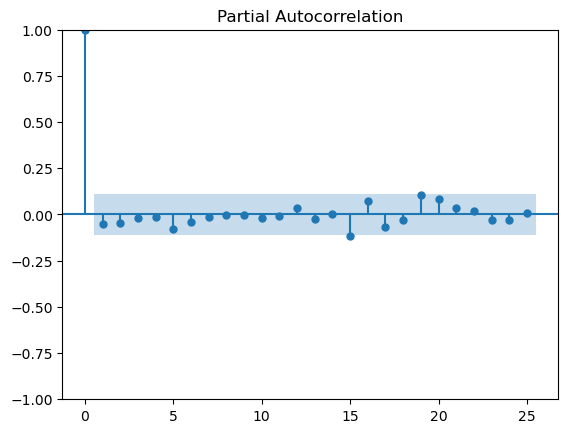

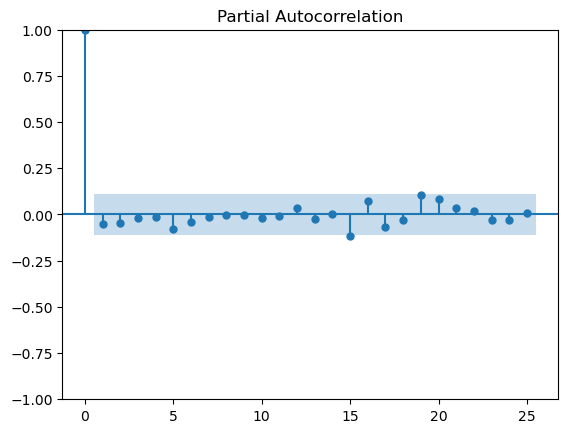

In [358]:
plot_pacf(iv_slice.loc['2018-01-01':].pct_return_ptile.dropna()[::dte+1])

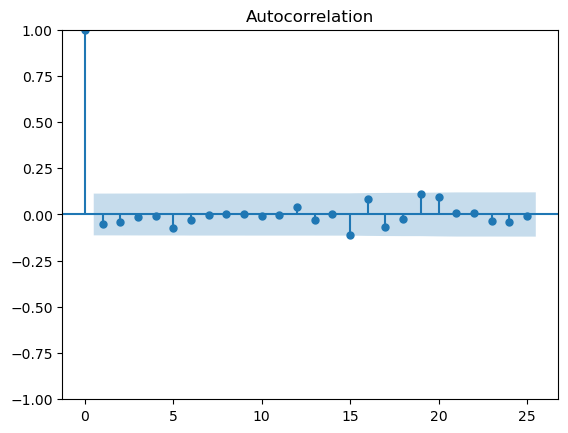

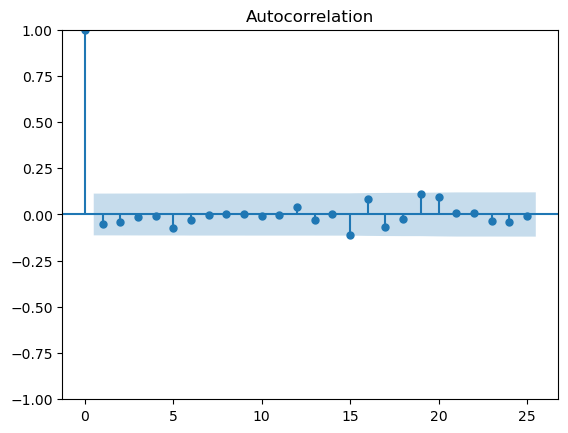

In [359]:
plot_acf(iv_slice.loc['2018-01-01':].pct_return_ptile.dropna()[::dte+1])

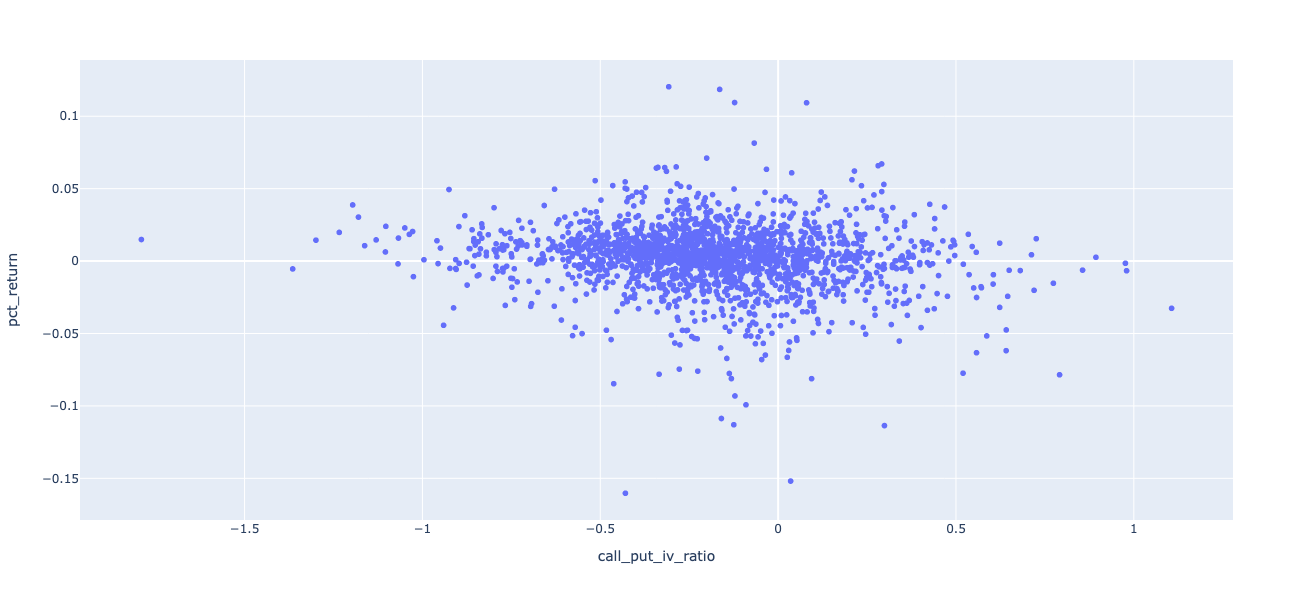

In [381]:
cp_ratio = iv_hist[f'IV_{dte}'].unstack('option_type').dropna().assign(
    call_put_iv_ratio = lambda x: np.log(x.C/x.P)
).call_put_iv_ratio

px.scatter(
    iv_slice.join(cp_ratio).dropna(),
    x = 'call_put_iv_ratio',
    y = 'pct_return',
    height = 600
)

In [380]:
iv_slice.join(cp_ratio).dropna()[['pct_return','call_put_iv_ratio']].corr()

pct_return  call_put_iv_ratio
pct_return           1.000000          -0.139422
call_put_iv_ratio   -0.139422           1.000000

In [385]:
iv_hist

IV_0      IV_1      IV_2      IV_3  \
quote_datetime      option_type                                           
2012-01-03 10:30:00 C            0.162501       NaN       NaN       NaN   
                    P            0.241900       NaN       NaN       NaN   
2012-01-03 11:30:00 C            0.198116       NaN       NaN       NaN   
                    P            0.211975       NaN       NaN       NaN   
2012-01-03 12:30:00 C            0.218104       NaN       NaN       NaN   
...                                   ...       ...       ...       ...   
2024-01-12 14:30:00 P            0.272338  0.081697  0.094820  0.091994   
2024-01-12 15:30:00 C            0.495551  0.078661  0.085461  0.088451   
                    P            0.083288  0.053583  0.067945  0.073362   
2024-01-12 16:15:00 C            0.043830  0.061174  0.074346  0.077200   
                    P            0.080371  0.086129  0.095475  0.092981   

                                     IV_4      IV_5      IV_6      IV_7  \
quote_datetime      option_type                                           
2012-01-03 10:30:00 C                 NaN       NaN       NaN       NaN   
                    P                 NaN       NaN       NaN       NaN   
2012-01-03 11:30:00 C                 NaN       NaN       NaN       NaN   
                    P                 NaN       NaN       NaN       NaN   
2012-01-03 12:30:00 C                 NaN       NaN       NaN       NaN   
...                                   ...       ...       ...       ...   
2024-01-12 14:30:00 P            0.092068  0.092251  0.089718  0.092914   
2024-01-12 15:30:00 C            0.096047  0.089069  0.095105  0.101876   
                    P            0.076520  0.086382  0.089247  0.097172   
2024-01-12 16:15:00 C            0.079286  0.085528  0.089179  0.095753   
                    P            0.093098  0.096306  0.097424  0.098367   

                                     IV_8      IV_9  ...  IV_20  IV_21  IV_22  \
quote_datetime      option_type                      ...                        
2012-01-03 10:30:00 C                 NaN       NaN  ...    NaN    NaN    NaN   
                    P                 NaN       NaN  ...    NaN    NaN    NaN   
2012-01-03 11:30:00 C                 NaN       NaN  ...    NaN    NaN    NaN   
                    P                 NaN       NaN  ...    NaN    NaN    NaN   
2012-01-03 12:30:00 C                 NaN       NaN  ...    NaN    NaN    NaN   
...                                   ...       ...  ...    ...    ...    ...   
2024-01-12 14:30:00 P            0.100488  0.097556  ...    NaN    NaN    NaN   
2024-01-12 15:30:00 C            0.089144  0.091385  ...    NaN    NaN    NaN   
                    P            0.095832  0.101818  ...    NaN    NaN    NaN   
2024-01-12 16:15:00 C            0.090847  0.100583  ...    NaN    NaN    NaN   
                    P            0.102115  0.105341  ...    NaN    NaN    NaN   

                                 IV_23  IV_24  IV_25  IV_26  IV_27  IV_28  \
quote_datetime      option_type                                             
2012-01-03 10:30:00 C              NaN    NaN    NaN    NaN    NaN    NaN   
                    P              NaN    NaN    NaN    NaN    NaN    NaN   
2012-01-03 11:30:00 C              NaN    NaN    NaN    NaN    NaN    NaN   
                    P              NaN    NaN    NaN    NaN    NaN    NaN   
2012-01-03 12:30:00 C              NaN    NaN    NaN    NaN    NaN    NaN   
...                                ...    ...    ...    ...    ...    ...   
2024-01-12 14:30:00 P              NaN    NaN    NaN    NaN    NaN    NaN   
2024-01-12 15:30:00 C              NaN    NaN    NaN    NaN    NaN    NaN   
                    P              NaN    NaN    NaN    NaN    NaN    NaN   
2024-01-12 16:15:00 C              NaN    NaN    NaN    NaN    NaN    NaN   
                    P              NaN    NaN    NaN    NaN    NaN    NaN   

                             